# 5.4 Visualizing what convnets learn

* Visualizing intermediate convnet outputs (intermediate activations)—Useful for
understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* Visualizing heatmaps of class activation in an image—Useful for understanding
which parts of an image were identified

### 5.4.1 Visualizing intermediate activations

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

#### Listing 5.25 Preprocessing a single image

In [5]:
img_path = './dog_cat/test1/4.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# <1> Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


## Listing 5.26 Displaying the test picture

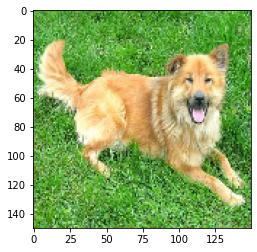

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()


##### Listing 5.27 Instantiating a model from an input tensor and a list of output tensors

In [7]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

#### Listing 5.28 Running the model in predict mode

import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 148, 148, 32)


In [9]:
activation_model

#### Listing 5.29 Visualizing the fourth channel

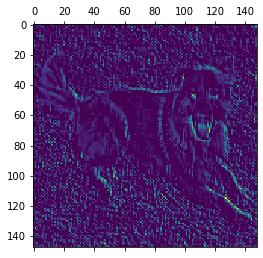

In [10]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')


#### Listing 5.30 Visualizing the seventh channel

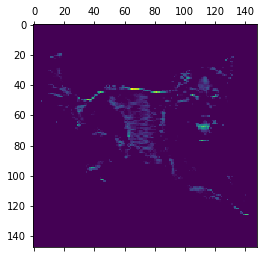

In [11]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

#### Listing 5.31 Visualizing every channel in every intermediate activation

<ipython-input-12-a07f8362c253>:15: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


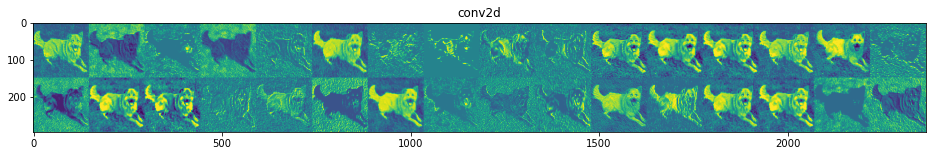

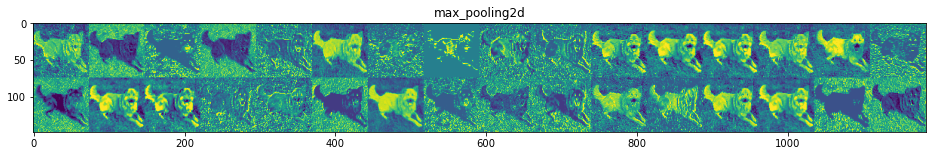

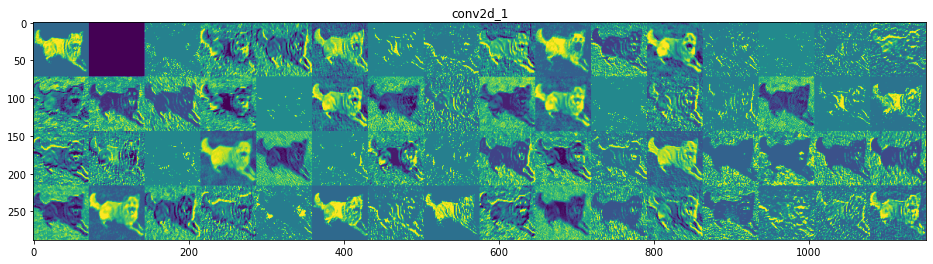

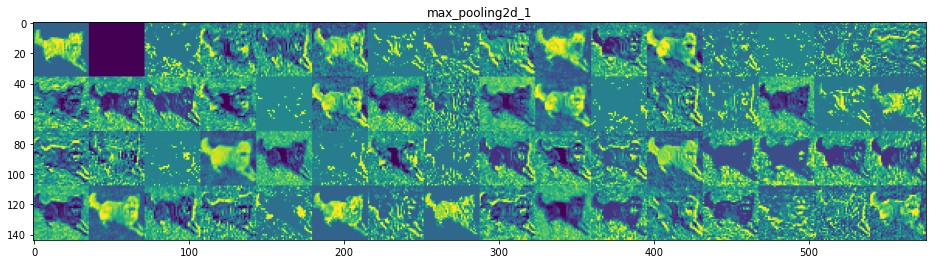

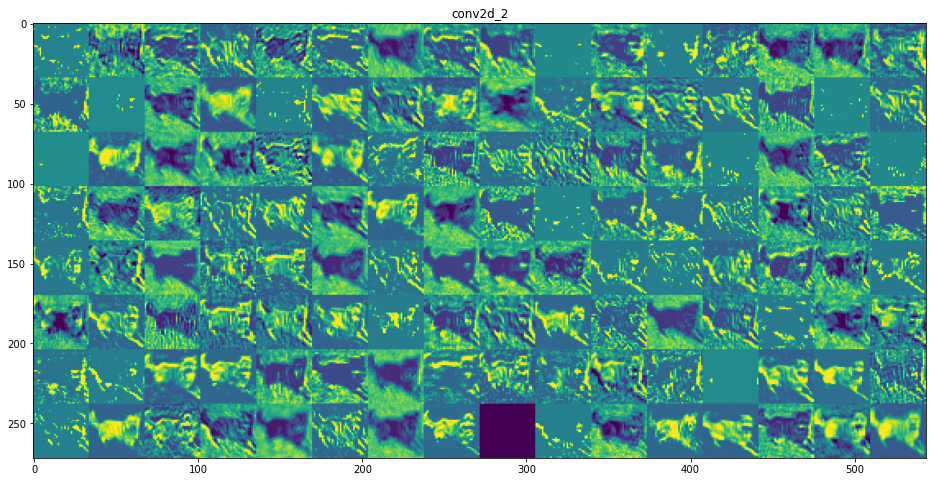

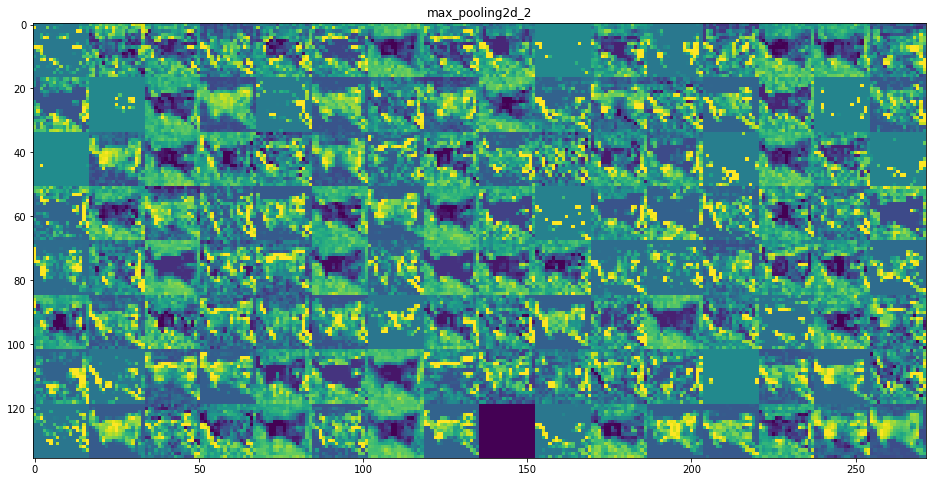

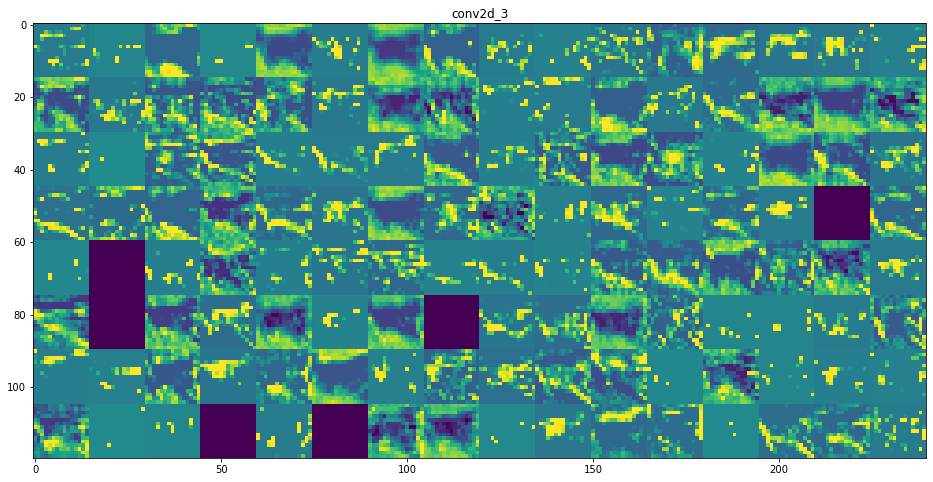

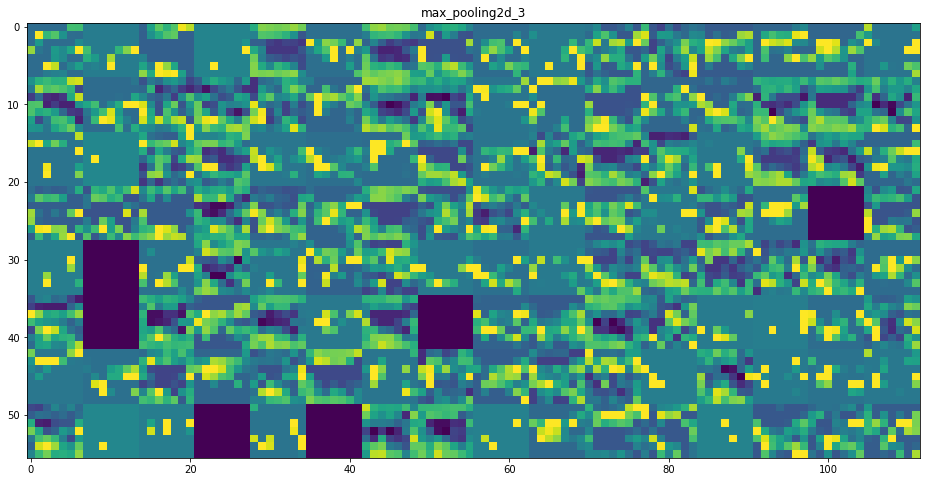

In [12]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


### Listing 5.32 Defining the loss tensor for filter visualization


In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
            include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [14]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

### Listing 5.33 Obtaining the gradient of the loss with regard to the input


In [15]:
grads = K.gradients(loss, model.input)[0]
grads

<tf.Tensor 'gradients/block1_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(None, None, None, 3) dtype=float32>

**Listing 5.34 Gradient-normalization **

In [16]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
grads

<tf.Tensor 'truediv:0' shape=(None, None, None, 3) dtype=float32>

**Listing 5.35 Fetching Numpy output values given Numpy input values**

In [17]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

**Listing 5.36 Loss maximization via stochastic gradient descent**

In [18]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

**Listing 5.37 Utility function to convert a tensor into a valid image**

In [19]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

**Listing 5.38 Function to generate filter visualizations**

In [20]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return deprocess_image(img)

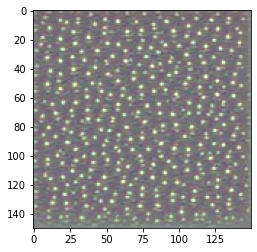

In [21]:
plt.imshow(generate_pattern('block3_conv1', 0))

**Listing 5.39 Generating a grid of all filter response patterns in a layer**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


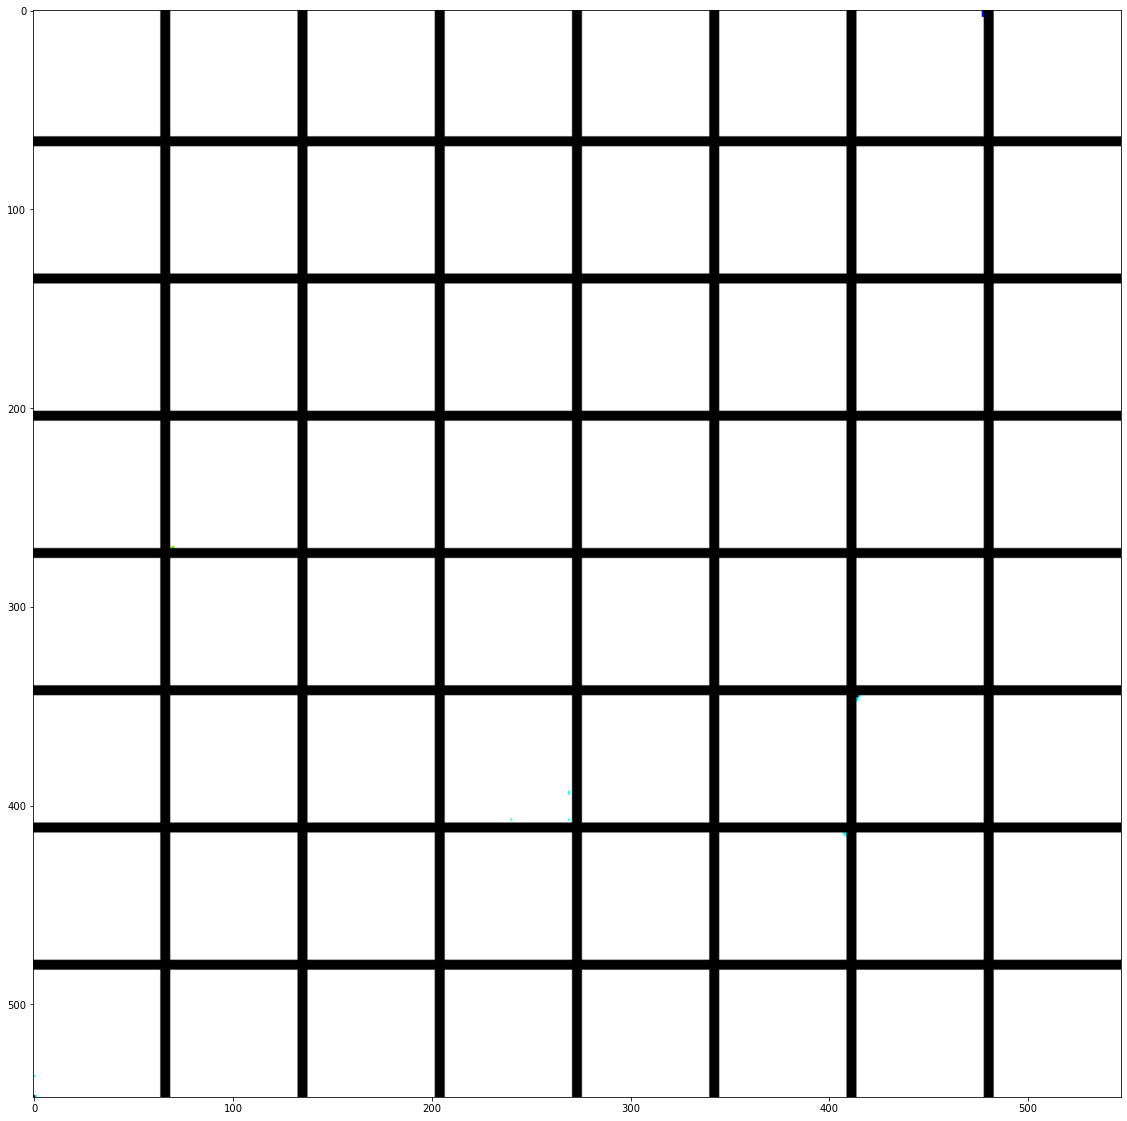

In [23]:
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

**5.4.3 Visualizing heatmaps of class activation**

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')


553467904/553467096 [==============================] - 366s 1us/step


In [27]:
img_path = 'abc.jpg'
img = image.load_img(img_path, target_size=(224, 224))
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [28]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 9us/step
Predicted: [('n02504458', 'African_elephant', 0.914756), ('n01871265', 'tusker', 0.08050947), ('n02504013', 'Indian_elephant', 0.004628111)]


In [29]:
np.argmax(preds[0])


386

**Listing 5.42 Setting up the Grad-CAM algorithm**

In [32]:
african_e66lephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_e66lephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

**Listing 5.43 Heatmap post-processing**


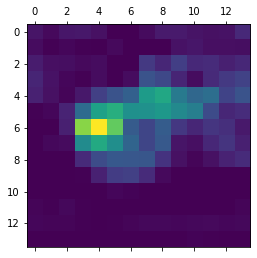

In [33]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Listing 5.44 Superimposing the heatmap with the original picture**

In [36]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('HeatMap(FromlocalMahine).jpg', superimposed_img)

True

<img src="https://github.com/EnggQasim/Quarter3_Batch3_Islamabad/blob/main/Chapter5/ElephentHeatMap.jpg?raw=true">